# File Preprocessing  

In [1]:
import pandas as pd
import numpy as np
import cv2
from pathlib import Path
import os
import shutil
from glob import glob
import matplotlib.pyplot as plt

In [2]:
cwd_path = Path.cwd()

In [3]:
og_train_path = os.path.join(cwd_path, "fruits-360/Training")
og_test_path  = os.path.join(cwd_path, "fruits-360/Test")

In [4]:
def getRandomFruitDirs(classCount):
    return np.random.choice(os.listdir(og_train_path), classCount, replace=False)

In [5]:
def MakeDirs(srcDir, newDirs):
    
    if type(newDirs) == str: 
        dirpath = os.path.join(srcDir, newDirs)
        if os.path.isdir(dirpath): 
            shutil.rmtree(dirpath)
        
        os.mkdir(dirpath)
    
    
    if type(newDirs) == list:    
        for dirname in newDirs:
            dirpath = os.path.join(srcDir, dirname)
            if os.path.isdir(dirpath):
                shutil.rmtree(dirpath)
        
            os.mkdir(dirpath)

In [6]:
def transferFile(srcPaths, destDir):
    if not os.path.isdir(destDir):     
        os.mkdir(destDir)
        
    for idx, imagePth in enumerate(srcPaths): 
        dPath = os.path.join(destDir, f"img{idx}.jpg")
        os.symlink(imagePth, dPath)
    

In [7]:
def getImageMatrix(links, title, image_size):

    sub_matrix = np.zeros(image_size[0] * image_size[1] * 3)
    labels = []
    for link in links: 
        vect_item = cv2.imread(link)
        vect_item = cv2.resize(vect_item, image_size)
        vect_item = cv2.cvtColor(vect_item, cv2.COLOR_BGR2RGB)
        sub_matrix = np.vstack((sub_matrix, vect_item.flatten()))
        labels.append(title)
        
    return sub_matrix[1:]/255, np.array(labels)

In [8]:
def getSamplesDir(sampleSize, valSize, testSize, selectedFruits, classDist = None): 
    trainSize = 1 - (valSize + testSize)
    train_fn = []
    test_fn = []
    val_fn = []

    if classDist is None: 
        cDist = np.ones(selectedFruits.shape[0]) * 1/selectedFruits.shape[0]
    else: 
        cDist = classDist
    
    if np.abs(np.sum(cDist) - 1) > 1e-9:
        raise Exception("Class Distribution is greater than one!")

        
    if testSize <= 0: 
        raise Exception("Training sample size too small!")

    train_sample_sz = int(trainSize * sampleSize)
    val_sample_sz = int(valSize * sampleSize) 
    test_sample_sz = int(testSize * sampleSize)

    subset_dir = "ML_FINAL_PROJECT/fruits-360"
    MakeDirs(subset_dir, "Subsets")
    
    subset_dir = "ML_FINAL_PROJECT/fruits-360/Subsets"
    
    subs = ["Train_sub", "Validation_sub", "Test_sub"]
    MakeDirs("ML_FINAL_PROJECT/fruits-360/Subsets", subs)

    for idx, fruit in enumerate(selectedFruits): 
        globbed_train = glob(os.path.join(og_train_path, fruit, "*.jp*g"))
        globbed_test = glob(os.path.join(og_test_path, fruit, "*.jp*g"))
        
        train_fn = np.random.choice(globbed_train, int(train_sample_sz * cDist[idx]), replace = False)
        testval_fn = np.random.choice(globbed_test, int((test_sample_sz  + val_sample_sz)*cDist[idx]), replace = False)

        test_fn, val_fn = testval_fn[ : int(test_sample_sz * cDist[idx])],  testval_fn[int(test_sample_sz * cDist[idx]) + 1 :]
        
        transferFile(train_fn, os.path.join(subset_dir, subs[0], fruit))
        transferFile(val_fn, os.path.join(subset_dir, subs[1], fruit))
        transferFile(test_fn, os.path.join(subset_dir, subs[2], fruit)) 

In [9]:
def getSamplesMat(sampleSize, selectedFruits, classDist = None, resize = (100, 100)): 
    matrix = np.zeros(shape = (1, resize[0] * resize[1] * 3))
    labels = np.zeros(0)

    if classDist is None: 
        cDist = np.ones(selectedFruits.shape[0]) * 1/selectedFruits.shape[0]
    else: 
        cDist = classDist
    
    if np.abs(np.sum(cDist) - 1) > 1e-9:
        raise Exception("Class Distribution is greater than one!")
        return 
        

    for idx, fruit in enumerate(selectedFruits): 
        globbed_train = glob(os.path.join(og_train_path, fruit, "*.jp*g"))
        globbed_test = glob(os.path.join(og_test_path, fruit, "*.jp*g"))
        
        fn = np.random.choice(globbed_train + globbed_test, int(sampleSize * cDist[idx]) ,replace = False)
        res_matrix, new_labels = getImageMatrix(fn, fruit,resize)        
        
        matrix = np.vstack([matrix, res_matrix])
        labels = np.concatenate([labels, new_labels])
        
    return matrix[1:], labels, fn[0]

In [10]:
def GrayScaleImageSquare(dataset, flatten=True): 

    if len(dataset.shape) == 2:      
        try: 
            dim = int(np.floor(np.sqrt(dataset.shape[1]/3)))
        except: 
            raise Exception("Singular images may not work, use reshape(-1)")
    
        
        try: 
            dataset = dataset.reshape(-1, dim, dim, 3)
        except: 
            raise Exception("Input image is probably not colored")
    elif len(dataset.shape) == 4: 
        dim = dataset.shape[1]
                           
    grayConv = np.zeros(shape = [dataset.shape[0], dim, dim]); 
    for idx, image in enumerate(dataset): 
        gray_image = cv2.cvtColor(image.astype('float32'), cv2.COLOR_BGR2GRAY)
        grayConv[idx] = gray_image

    if flatten == True: 
        grayConv = grayConv.reshape(-1, dim**2)
        
    return grayConv
def GrayScaleImageSquare(dataset, flatten=True): 

    if len(dataset.shape) == 2:      
        try: 
            dim = int(np.floor(np.sqrt(dataset.shape[1]/3)))
        except: 
            raise Exception("Singular images may not work, use reshape(-1)")
    
        
        try: 
            dataset = dataset.reshape(-1, dim, dim, 3)
        except: 
            raise Exception("Input image is probably not colored")
    elif len(dataset.shape) == 4: 
        dim = dataset.shape[1]
                           
    grayConv = np.zeros(shape = [dataset.shape[0], dim, dim]); 
    for idx, image in enumerate(dataset): 
        gray_image = cv2.cvtColor(image.astype('float32'), cv2.COLOR_BGR2GRAY)
        grayConv[idx] = gray_image

    if flatten == True: 
        grayConv = grayConv.reshape(-1, dim**2)
        
    return grayConv

# ANN

## Testing similar color but different shapes

In [11]:
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, RMSprop, Nadam

sample_size = 1000
classDist = None
resizes = (20,20)

C:\Users\John\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 - Validation Loss: 0.0643 - Validation Accuracy: 0.9900
Fold 2 - Validation Loss: 0.0954 - Validation Accuracy: 0.9700
Fold 3 - Validation Loss: 0.0791 - Validation Accuracy: 0.9700
Fold 4 - Validation Loss: 0.0876 - Validation Accuracy: 0.9700
Fold 5 - Validation Loss: 0.0572 - Validation Accuracy: 0.9850
Cross-Validation Score: 0.9770 ± 0.0087
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.0920 - loss: 3.0077 - val_accuracy: 0.3500 - val_loss: 2.2647
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4398 - loss: 1.8117 - val_accuracy: 0.6500 - val_loss: 1.1776
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.6872 - loss: 0.9607 - val_accuracy: 0.8188 - val_loss: 0.7119
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8822 - loss: 0.4568 - val_accuracy: 0.8813 - val_loss: 0.3976
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9468 - loss: 0.2384 - val_accuracy: 0.9312 - val_loss: 0.2558
Epoch 6/10

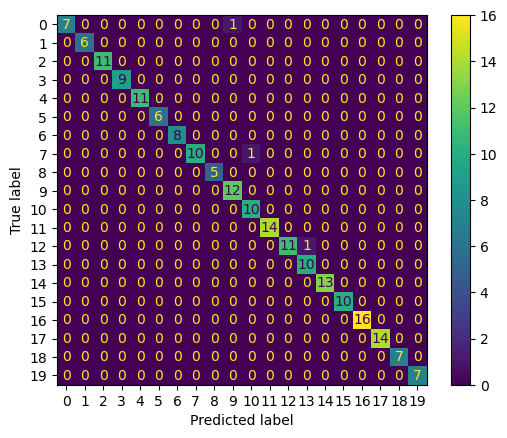

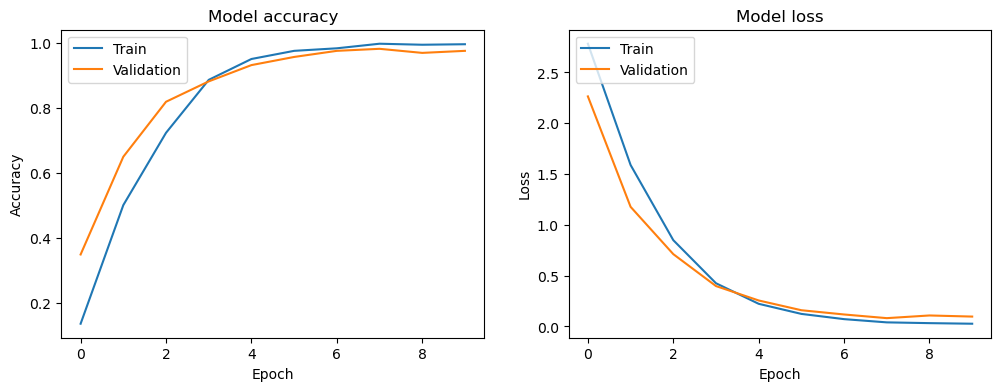

In [12]:
#Testing Red Fruits
fruits = [
    "Grape Pink", "Tomato Cherry Red", "Tomato Maroon", "Apple Pink Lady", "Apricot",
    "Tomato 1", "Peach", "Cherry 2", "Apple Braeburn", "Tomato Heart",
    "Pepper Red", "Pomegranate", "Mango Red", "Pear Red", "Kaki", "Onion Red",
    "Strawberry", "Tamarillo", "Cucumber Ripe", "Pear Forelle"
]
fruits = np.array(fruits)

# Generate dataset 
image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)

# Encode labels to numeric values
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Reshape data if needed
image_dataset = image_dataset.reshape((image_dataset.shape[0], -1))

# Function to create the ANN model
def create_ann_model(input_shape, num_classes):
    model = Sequential([
        Dense(1024, activation='relu', input_shape=input_shape),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Nadam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
cv_scores = []

for train_index, val_index in kf.split(image_dataset):
    X_train, X_val = image_dataset[train_index], image_dataset[val_index]
    y_train, y_val = labels_encoded[train_index], labels_encoded[val_index]
    
    model = create_ann_model((resizes[0] * resizes[1] * 3,), len(fruits))
    
    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), verbose=0)
    
    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f'Fold {fold_no} - Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f}')
    
    cv_scores.append(val_accuracy)
    fold_no += 1

print(f'Cross-Validation Score: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}')

# Train final model on the entire training data
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_encoded, test_size=0.2, random_state=42)
final_model = create_ann_model((resizes[0] * resizes[1] * 3,), len(fruits))
history = final_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)

# Evaluate the final model on the test data
y_pred_ann = np.argmax(final_model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred_ann, target_names=label_encoder.classes_))
cm = confusion_matrix(y_test, y_pred_ann)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

C:\Users\John\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 - Validation Loss: 0.3217 - Validation Accuracy: 0.9150
Fold 2 - Validation Loss: 0.1991 - Validation Accuracy: 0.9450
Fold 3 - Validation Loss: 0.2431 - Validation Accuracy: 0.9200
Fold 4 - Validation Loss: 0.3332 - Validation Accuracy: 0.8900
Fold 5 - Validation Loss: 0.2624 - Validation Accuracy: 0.9150
Cross-Validation Accuracy: 0.9170 ± 0.0175
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.1455 - loss: 2.8154 - val_accuracy: 0.3313 - val_loss: 1.9491
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4303 - loss: 1.7032 - val_accuracy: 0.5750 - val_loss: 1.2771
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6002 - loss: 1.1114 - val_accuracy: 0.7500 - val_loss: 0.8597
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7824 - loss: 0.7802 - val_accuracy: 0.8313 - val_loss: 0.6138
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8387 - loss: 0.5106 - val_accuracy: 0.8125 - val_loss: 0.5971
Epoch 6

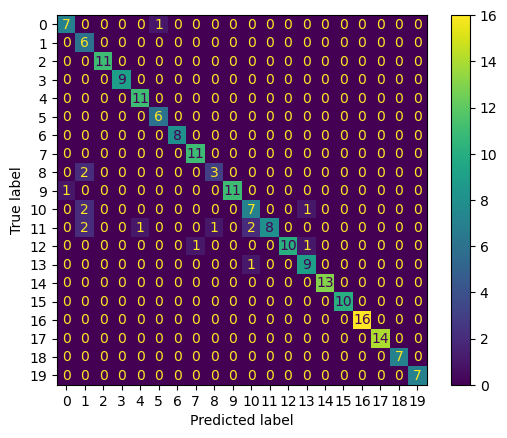

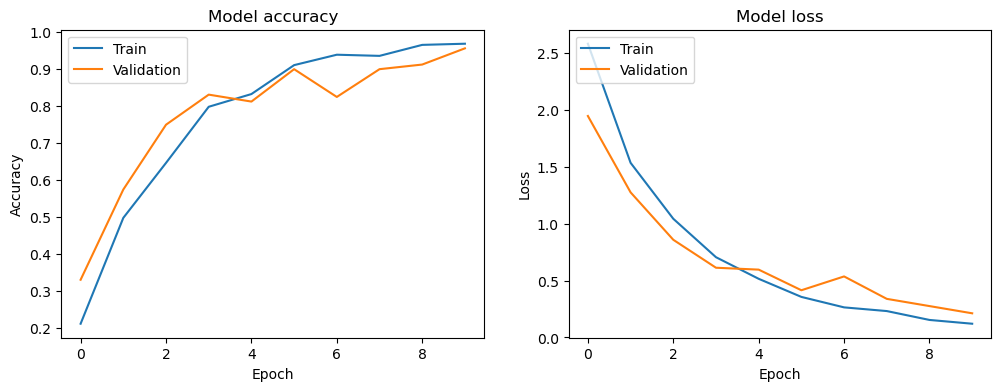

In [13]:
#Testing Red Fruits (greyscaled)
fruits = [
    "Grape Pink", "Tomato Cherry Red", "Tomato Maroon", "Apple Pink Lady", "Apricot",
    "Tomato 1", "Peach", "Cherry 2", "Apple Braeburn", "Tomato Heart",
    "Pepper Red", "Pomegranate", "Mango Red", "Pear Red", "Kaki", "Onion Red",
    "Strawberry", "Tamarillo", "Cucumber Ripe", "Pear Forelle"
]
fruits = np.array(fruits)

# Generate dataset 
image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
image_dataset = GrayScaleImageSquare(image_dataset)

# Encode labels to numeric values
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Reshape data for grayscale images
image_dataset = image_dataset.reshape((image_dataset.shape[0], resizes[0] * resizes[1]))

# Function to create the ANN model
def create_ann_model(input_shape, num_classes):
    model = Sequential([
        Dense(1024, activation='relu', input_shape=input_shape),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Nadam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
cv_scores = []

for train_index, val_index in kf.split(image_dataset):
    X_train, X_val = image_dataset[train_index], image_dataset[val_index]
    y_train, y_val = labels_encoded[train_index], labels_encoded[val_index]
    
    model = create_ann_model((resizes[0] * resizes[1],), len(fruits))
    
    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), verbose=0)
    
    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f'Fold {fold_no} - Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f}')
    
    cv_scores.append(val_accuracy)
    fold_no += 1

# Cross-Validation Accuracy
cross_val_accuracy = np.mean(cv_scores)
print(f'Cross-Validation Accuracy: {cross_val_accuracy:.4f} ± {np.std(cv_scores):.4f}')

# Train final model on the entire training data
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_encoded, test_size=0.2, random_state=42)
final_model = create_ann_model((resizes[0] * resizes[1],), len(fruits))
history = final_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)

# Evaluate the final model on the test data
y_pred_ann = np.argmax(final_model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred_ann, target_names=label_encoder.classes_))
cm = confusion_matrix(y_test, y_pred_ann)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

C:\Users\John\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 - Validation Loss: 0.0301 - Validation Accuracy: 0.9950
Fold 2 - Validation Loss: 0.0227 - Validation Accuracy: 1.0000
Fold 3 - Validation Loss: 0.0295 - Validation Accuracy: 0.9950
Fold 4 - Validation Loss: 0.0676 - Validation Accuracy: 0.9750
Fold 5 - Validation Loss: 0.0430 - Validation Accuracy: 0.9900
Cross-Validation Score: 0.9910 ± 0.0086
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.0576 - loss: 3.1719 - val_accuracy: 0.2062 - val_loss: 2.6407
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.3163 - loss: 2.3007 - val_accuracy: 0.5063 - val_loss: 1.7423
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6419 - loss: 1.2768 - val_accuracy: 0.7750 - val_loss: 0.8973
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8152 - loss: 0.6438 - val_accuracy: 0.8625 - val_loss: 0.5348
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9249 - loss: 0.3172 - val_accuracy: 0.9438 - val_loss: 0.2595
Epoch 6/10

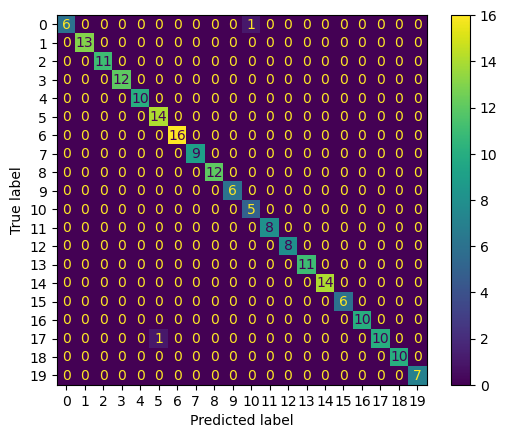

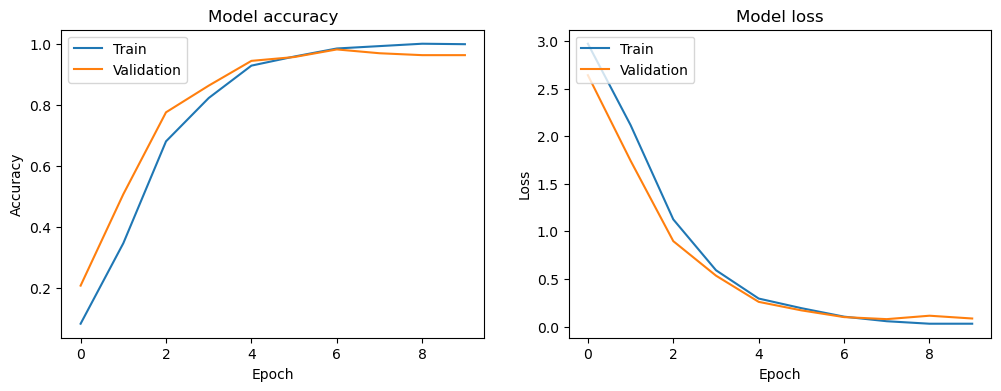

In [14]:
#Yellow/Orange
fruits = [
    "Pepper Yellow", "Grapefruit Pink", "Tomato Yellow", "Mandarine", "Tangelo",
    "Grapefruit White", "Cherry Wax Yellow", "Kaki", "Peach 2", "Apple Red Yellow 1",
    "Lemon", "Pomelo Sweetie", "Pear Red", "Pepper Orange", "Peach", "Maracuja", 
    "Apricot", "Cucumber Ripe 2", "Carambula", "Tomato 2"
]
fruits = np.array(fruits)

# Generate dataset 
image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)

# Encode labels to numeric values
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Reshape data if needed
image_dataset = image_dataset.reshape((image_dataset.shape[0], -1))

# Function to create the ANN model
def create_ann_model(input_shape, num_classes):
    model = Sequential([
        Dense(1024, activation='relu', input_shape=input_shape),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Nadam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
cv_scores = []

for train_index, val_index in kf.split(image_dataset):
    X_train, X_val = image_dataset[train_index], image_dataset[val_index]
    y_train, y_val = labels_encoded[train_index], labels_encoded[val_index]
    
    model = create_ann_model((resizes[0] * resizes[1] * 3,), len(fruits))
    
    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), verbose=0)
    
    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f'Fold {fold_no} - Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f}')
    
    cv_scores.append(val_accuracy)
    fold_no += 1

print(f'Cross-Validation Score: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}')

# Train final model on the entire training data
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_encoded, test_size=0.2, random_state=42)
final_model = create_ann_model((resizes[0] * resizes[1] * 3,), len(fruits))
history = final_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)

# Evaluate the final model on the test data
y_pred_ann = np.argmax(final_model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred_ann, target_names=label_encoder.classes_))
cm = confusion_matrix(y_test, y_pred_ann)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

C:\Users\John\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 - Validation Loss: 0.3025 - Validation Accuracy: 0.9100
Fold 2 - Validation Loss: 0.2853 - Validation Accuracy: 0.9000
Fold 3 - Validation Loss: 0.2938 - Validation Accuracy: 0.8900
Fold 4 - Validation Loss: 0.4329 - Validation Accuracy: 0.8400
Fold 5 - Validation Loss: 0.4018 - Validation Accuracy: 0.8850
Cross-Validation Accuracy: 0.8850 ± 0.0241
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.0821 - loss: 2.9749 - val_accuracy: 0.1937 - val_loss: 2.3914
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3552 - loss: 2.0257 - val_accuracy: 0.5125 - val_loss: 1.5447
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5813 - loss: 1.2752 - val_accuracy: 0.5437 - val_loss: 1.3542
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7390 - loss: 0.8546 - val_accuracy: 0.6438 - val_loss: 0.9876
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8208 - loss: 0.6310 - val_accuracy: 0.7750 - val_loss: 0.8073
Epoch 6

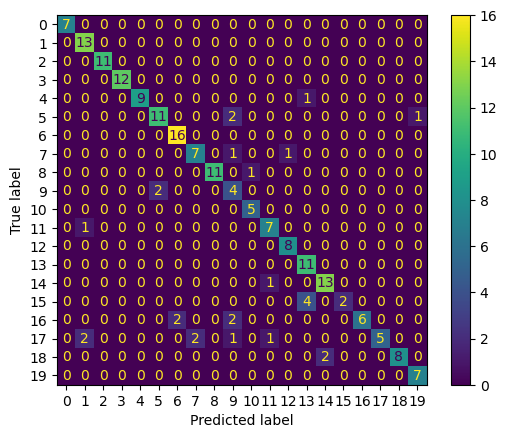

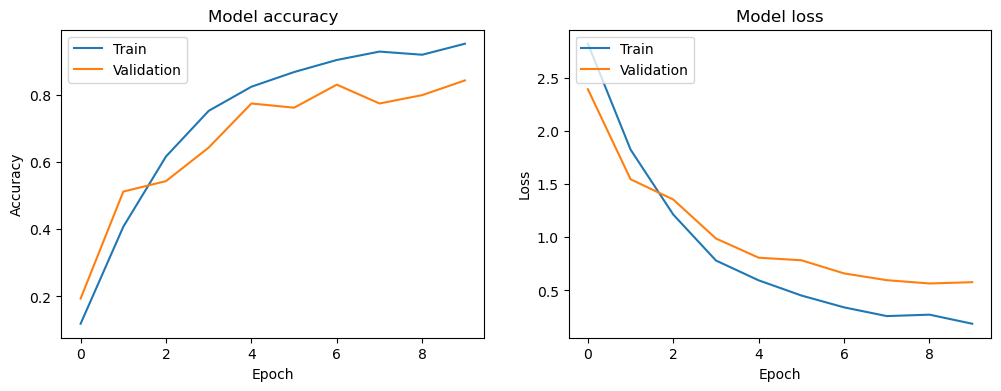

In [15]:
#Yellow/Orange (greyscaled)
fruits = [
    "Pepper Yellow", "Grapefruit Pink", "Tomato Yellow", "Mandarine", "Tangelo",
    "Grapefruit White", "Cherry Wax Yellow", "Kaki", "Peach 2", "Apple Red Yellow 1",
    "Lemon", "Pomelo Sweetie", "Pear Red", "Pepper Orange", "Peach", "Maracuja", 
    "Apricot", "Cucumber Ripe 2", "Carambula", "Tomato 2"
]
fruits = np.array(fruits)

# Generate dataset 
image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
image_dataset = GrayScaleImageSquare(image_dataset)

# Encode labels to numeric values
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Reshape data for grayscale images
image_dataset = image_dataset.reshape((image_dataset.shape[0], resizes[0] * resizes[1]))

# Function to create the ANN model
def create_ann_model(input_shape, num_classes):
    model = Sequential([
        Dense(1024, activation='relu', input_shape=input_shape),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Nadam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
cv_scores = []

for train_index, val_index in kf.split(image_dataset):
    X_train, X_val = image_dataset[train_index], image_dataset[val_index]
    y_train, y_val = labels_encoded[train_index], labels_encoded[val_index]
    
    model = create_ann_model((resizes[0] * resizes[1],), len(fruits))
    
    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), verbose=0)
    
    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f'Fold {fold_no} - Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f}')
    
    cv_scores.append(val_accuracy)
    fold_no += 1

# Cross-Validation Accuracy
cross_val_accuracy = np.mean(cv_scores)
print(f'Cross-Validation Accuracy: {cross_val_accuracy:.4f} ± {np.std(cv_scores):.4f}')

# Train final model on the entire training data
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_encoded, test_size=0.2, random_state=42)
final_model = create_ann_model((resizes[0] * resizes[1],), len(fruits))
history = final_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)

# Evaluate the final model on the test data
y_pred_ann = np.argmax(final_model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred_ann, target_names=label_encoder.classes_))
cm = confusion_matrix(y_test, y_pred_ann)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

C:\Users\John\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 - Validation Loss: 0.0682 - Validation Accuracy: 0.9750
Fold 2 - Validation Loss: 0.0239 - Validation Accuracy: 0.9950
Fold 3 - Validation Loss: 0.0642 - Validation Accuracy: 0.9800
Fold 4 - Validation Loss: 0.3038 - Validation Accuracy: 0.8950
Fold 5 - Validation Loss: 0.0256 - Validation Accuracy: 0.9950
Cross-Validation Score: 0.9680 ± 0.0374
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.1357 - loss: 2.8495 - val_accuracy: 0.4875 - val_loss: 1.5924
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5799 - loss: 1.2808 - val_accuracy: 0.6938 - val_loss: 0.7953
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8387 - loss: 0.5273 - val_accuracy: 0.8938 - val_loss: 0.3069
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9436 - loss: 0.2194 - val_accuracy: 0.9062 - val_loss: 0.2440
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9530 - loss: 0.1578 - val_accuracy: 0.9500 - val_loss: 0.1614
Epoch 6/10

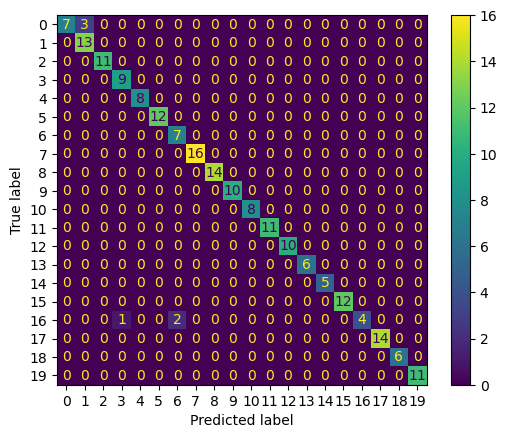

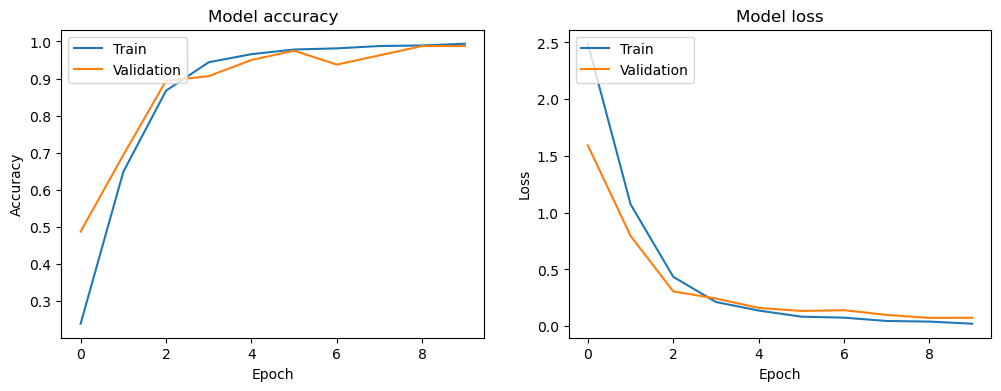

In [16]:
#Testing Green Fruits
fruits = ['Pepper Green', 'Grape White 4', 'Grape Blue',
         'Tomato not Ripened', 'Avocado', 'Grape White 3',
         'Cherry Wax Black', 'Blueberry', 'Cherry 1', 'Plum 3', 'Plum',
         'Nut Forest', 'Mango', 'Pomelo Sweetie', 'Limes', 'Pineapple',
         'Apple Granny Smith', 'Guava', 'Watermelon', 'Apple Golden 3']
fruits = np.array(fruits)

# Generate dataset 
image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)

# Encode labels to numeric values
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Reshape data if needed
image_dataset = image_dataset.reshape((image_dataset.shape[0], -1))

# Function to create the ANN model
def create_ann_model(input_shape, num_classes):
    model = Sequential([
        Dense(1024, activation='relu', input_shape=input_shape),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Nadam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
cv_scores = []

for train_index, val_index in kf.split(image_dataset):
    X_train, X_val = image_dataset[train_index], image_dataset[val_index]
    y_train, y_val = labels_encoded[train_index], labels_encoded[val_index]
    
    model = create_ann_model((resizes[0] * resizes[1] * 3,), len(fruits))
    
    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), verbose=0)
    
    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f'Fold {fold_no} - Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f}')
    
    cv_scores.append(val_accuracy)
    fold_no += 1

print(f'Cross-Validation Score: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}')

# Train final model on the entire training data
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_encoded, test_size=0.2, random_state=42)
final_model = create_ann_model((resizes[0] * resizes[1] * 3,), len(fruits))
history = final_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)

# Evaluate the final model on the test data
y_pred_ann = np.argmax(final_model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred_ann, target_names=label_encoder.classes_))
cm = confusion_matrix(y_test, y_pred_ann)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

C:\Users\John\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 - Validation Loss: 0.1227 - Validation Accuracy: 0.9750
Fold 2 - Validation Loss: 0.1752 - Validation Accuracy: 0.9650
Fold 3 - Validation Loss: 0.2684 - Validation Accuracy: 0.9200
Fold 4 - Validation Loss: 0.1506 - Validation Accuracy: 0.9600
Fold 5 - Validation Loss: 0.2036 - Validation Accuracy: 0.9150
Cross-Validation Accuracy: 0.9470 ± 0.0246
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.1244 - loss: 2.8160 - val_accuracy: 0.5500 - val_loss: 1.8020
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5267 - loss: 1.4954 - val_accuracy: 0.5500 - val_loss: 1.2078
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7162 - loss: 0.8742 - val_accuracy: 0.7500 - val_loss: 0.7040
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8119 - loss: 0.5611 - val_accuracy: 0.8062 - val_loss: 0.4954
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8734 - loss: 0.3646 - val_accuracy: 0.8250 - val_loss: 0.4982
Epoch 6

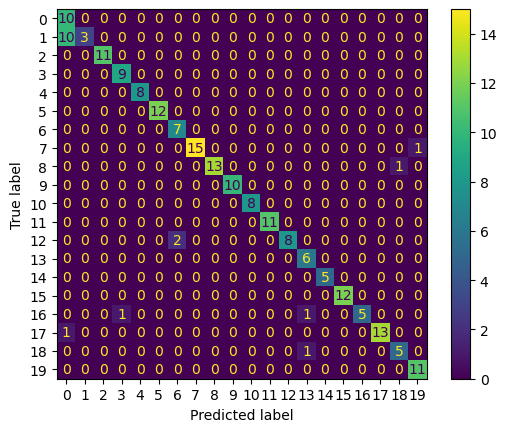

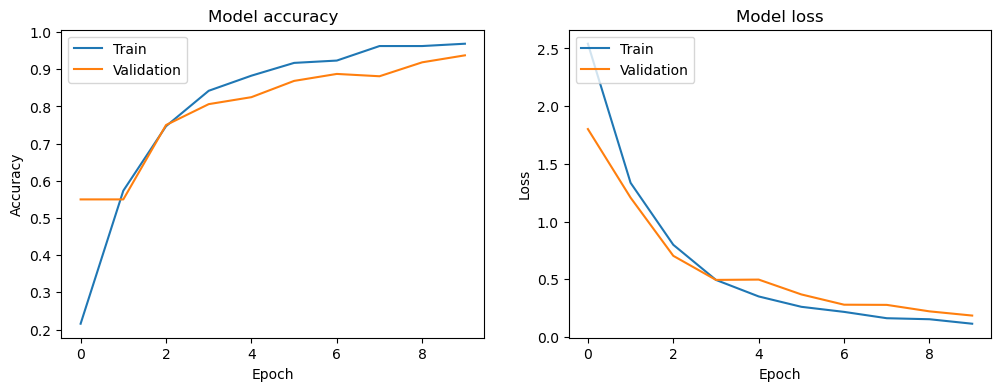

In [17]:
#Testing Green Fruits (greyscaled)
fruits = ['Pepper Green', 'Grape White 4', 'Grape Blue',
         'Tomato not Ripened', 'Avocado', 'Grape White 3',
         'Cherry Wax Black', 'Blueberry', 'Cherry 1', 'Plum 3', 'Plum',
         'Nut Forest', 'Mango', 'Pomelo Sweetie', 'Limes', 'Pineapple',
         'Apple Granny Smith', 'Guava', 'Watermelon', 'Apple Golden 3']
fruits = np.array(fruits)

# Generate dataset 
image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
image_dataset = GrayScaleImageSquare(image_dataset)

# Encode labels to numeric values
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Reshape data for grayscale images
image_dataset = image_dataset.reshape((image_dataset.shape[0], resizes[0] * resizes[1]))

# Function to create the ANN model
def create_ann_model(input_shape, num_classes):
    model = Sequential([
        Dense(1024, activation='relu', input_shape=input_shape),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Nadam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
cv_scores = []

for train_index, val_index in kf.split(image_dataset):
    X_train, X_val = image_dataset[train_index], image_dataset[val_index]
    y_train, y_val = labels_encoded[train_index], labels_encoded[val_index]
    
    model = create_ann_model((resizes[0] * resizes[1],), len(fruits))
    
    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), verbose=0)
    
    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f'Fold {fold_no} - Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f}')
    
    cv_scores.append(val_accuracy)
    fold_no += 1

# Cross-Validation Accuracy
cross_val_accuracy = np.mean(cv_scores)
print(f'Cross-Validation Accuracy: {cross_val_accuracy:.4f} ± {np.std(cv_scores):.4f}')

# Train final model on the entire training data
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_encoded, test_size=0.2, random_state=42)
final_model = create_ann_model((resizes[0] * resizes[1],), len(fruits))
history = final_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)

# Evaluate the final model on the test data
y_pred_ann = np.argmax(final_model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred_ann, target_names=label_encoder.classes_))
cm = confusion_matrix(y_test, y_pred_ann)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Testing similar shape but different colors

C:\Users\John\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 - Validation Loss: 0.0244 - Validation Accuracy: 0.9950
Fold 2 - Validation Loss: 0.0062 - Validation Accuracy: 1.0000
Fold 3 - Validation Loss: 0.0037 - Validation Accuracy: 1.0000
Fold 4 - Validation Loss: 0.0171 - Validation Accuracy: 0.9950
Fold 5 - Validation Loss: 0.0122 - Validation Accuracy: 1.0000
Cross-Validation Score: 0.9980 ± 0.0024
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.1366 - loss: 2.8704 - val_accuracy: 0.3875 - val_loss: 1.8116
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6199 - loss: 1.1822 - val_accuracy: 0.7937 - val_loss: 0.6039
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8305 - loss: 0.4778 - val_accuracy: 0.8750 - val_loss: 0.3541
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9620 - loss: 0.1730 - val_accuracy: 0.9688 - val_loss: 0.1359
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9866 - loss: 0.0881 - val_accuracy: 0.9812 - val_loss: 0.1314
Epoch 6/10

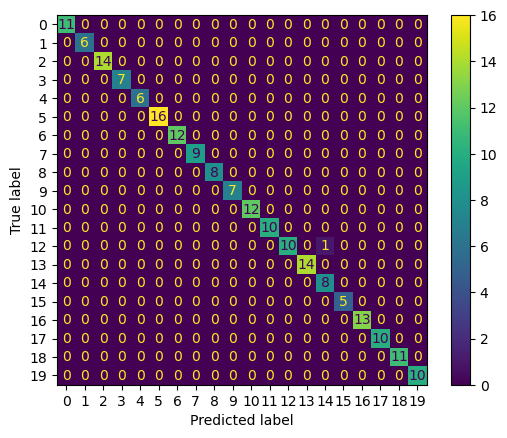

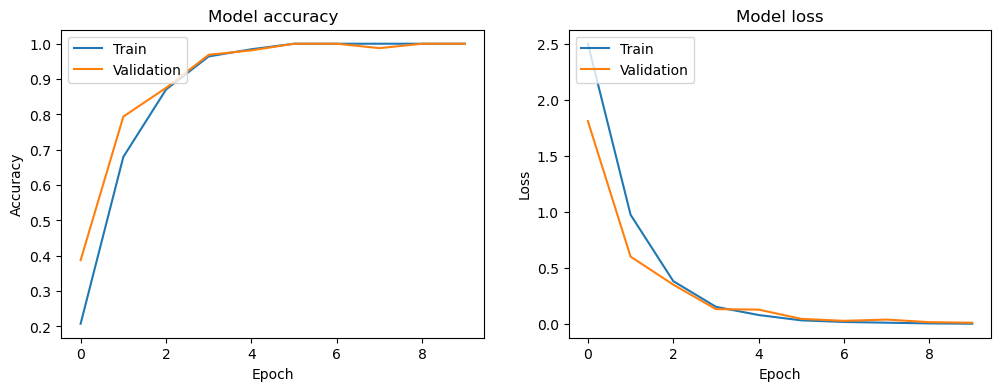

In [18]:
#Testing circular fruits
fruits = [
    "Cantaloupe 1", "Cantaloupe 2", "Cherry 1", "Cherry 2", "Apricot",
    "Cherry Wax Black", "Cherry Wax Red", "Cherry Wax Yellow", "Clementine",
    "Grape Blue", "Grape White", "Grapefruit Pink", "Nectarine", "Orange",
    "Peach", "Plum", "Plum 2", "Tomato Cherry Red", "Walnut", "Watermelon"
]
fruits = np.array(fruits)

# Generate dataset 
image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)

# Encode labels to numeric values
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Reshape data if needed
image_dataset = image_dataset.reshape((image_dataset.shape[0], -1))

# Function to create the ANN model
def create_ann_model(input_shape, num_classes):
    model = Sequential([
        Dense(1024, activation='relu', input_shape=input_shape),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Nadam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
cv_scores = []

for train_index, val_index in kf.split(image_dataset):
    X_train, X_val = image_dataset[train_index], image_dataset[val_index]
    y_train, y_val = labels_encoded[train_index], labels_encoded[val_index]
    
    model = create_ann_model((resizes[0] * resizes[1] * 3,), len(fruits))
    
    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), verbose=0)
    
    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f'Fold {fold_no} - Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f}')
    
    cv_scores.append(val_accuracy)
    fold_no += 1

print(f'Cross-Validation Score: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}')

# Train final model on the entire training data
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_encoded, test_size=0.2, random_state=42)
final_model = create_ann_model((resizes[0] * resizes[1] * 3,), len(fruits))
history = final_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)

# Evaluate the final model on the test data
y_pred_ann = np.argmax(final_model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred_ann, target_names=label_encoder.classes_))
cm = confusion_matrix(y_test, y_pred_ann)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

C:\Users\John\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 - Validation Loss: 0.0990 - Validation Accuracy: 0.9700
Fold 2 - Validation Loss: 0.0602 - Validation Accuracy: 0.9800
Fold 3 - Validation Loss: 0.0636 - Validation Accuracy: 0.9800
Fold 4 - Validation Loss: 0.0805 - Validation Accuracy: 0.9800
Fold 5 - Validation Loss: 0.0468 - Validation Accuracy: 0.9800
Cross-Validation Score: 0.9780 ± 0.0040
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.1258 - loss: 2.9176 - val_accuracy: 0.3250 - val_loss: 2.0399
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4541 - loss: 1.7280 - val_accuracy: 0.6750 - val_loss: 0.9134
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.7404 - loss: 0.7284 - val_accuracy: 0.8500 - val_loss: 0.5573
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8965 - loss: 0.3568 - val_accuracy: 0.8625 - val_loss: 0.4345
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9276 - loss: 0.2244 - val_accuracy: 0.9438 - val_loss: 0.1817
Epoch 6/10

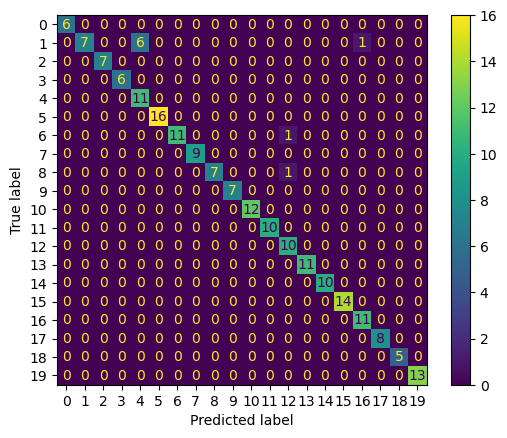

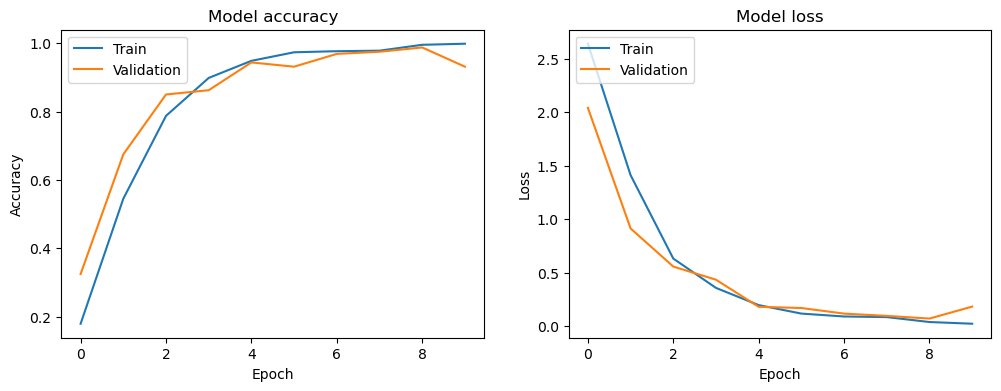

In [19]:
#Testing not quite Circular Fruits
fruits = [
    "Apple Braeburn", "Apple Crimson Snow", "Apple Golden 1", "Apple Granny Smith",
    "Apple Pink Lady", "Apple Red 1", "Apple Red Delicious", "Apple Red Yellow 1",
    "Beetroot", "Blueberry", "Fig", "Guava", "Lemon", "Limes", "Onion Red",
    "Onion White", "Pepper Red", "Lemon Meyer", "Mango Red", "Kiwi"
]
fruits = np.array(fruits)

# Generate dataset 
image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)

# Encode labels to numeric values
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Reshape data if needed
image_dataset = image_dataset.reshape((image_dataset.shape[0], -1))

# Function to create the ANN model
def create_ann_model(input_shape, num_classes):
    model = Sequential([
        Dense(1024, activation='relu', input_shape=input_shape),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Nadam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
cv_scores = []

for train_index, val_index in kf.split(image_dataset):
    X_train, X_val = image_dataset[train_index], image_dataset[val_index]
    y_train, y_val = labels_encoded[train_index], labels_encoded[val_index]
    
    model = create_ann_model((resizes[0] * resizes[1] * 3,), len(fruits))
    
    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), verbose=0)
    
    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f'Fold {fold_no} - Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f}')
    
    cv_scores.append(val_accuracy)
    fold_no += 1

print(f'Cross-Validation Score: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}')

# Train final model on the entire training data
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_encoded, test_size=0.2, random_state=42)
final_model = create_ann_model((resizes[0] * resizes[1] * 3,), len(fruits))
history = final_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)

# Evaluate the final model on the test data
y_pred_ann = np.argmax(final_model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred_ann, target_names=label_encoder.classes_))
cm = confusion_matrix(y_test, y_pred_ann)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

C:\Users\John\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 - Validation Loss: 0.5492 - Validation Accuracy: 0.8650
Fold 2 - Validation Loss: 0.1973 - Validation Accuracy: 0.9400
Fold 3 - Validation Loss: 0.3190 - Validation Accuracy: 0.8950
Fold 4 - Validation Loss: 0.2980 - Validation Accuracy: 0.8750
Fold 5 - Validation Loss: 0.2932 - Validation Accuracy: 0.9100
Cross-Validation Score: 0.8970 ± 0.0266
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.0643 - loss: 3.4211 - val_accuracy: 0.2562 - val_loss: 2.5027
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.2115 - loss: 2.4412 - val_accuracy: 0.4313 - val_loss: 1.7458
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.4769 - loss: 1.6567 - val_accuracy: 0.5562 - val_loss: 1.2875
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6749 - loss: 1.0404 - val_accuracy: 0.7188 - val_loss: 0.8948
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7325 - loss: 0.8754 - val_accuracy: 0.7875 - val_loss: 0.7119
Epoch 6/1

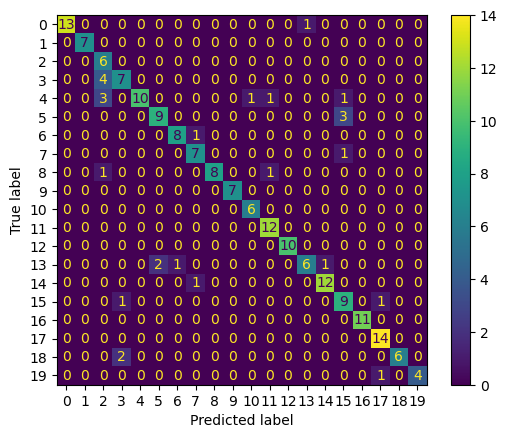

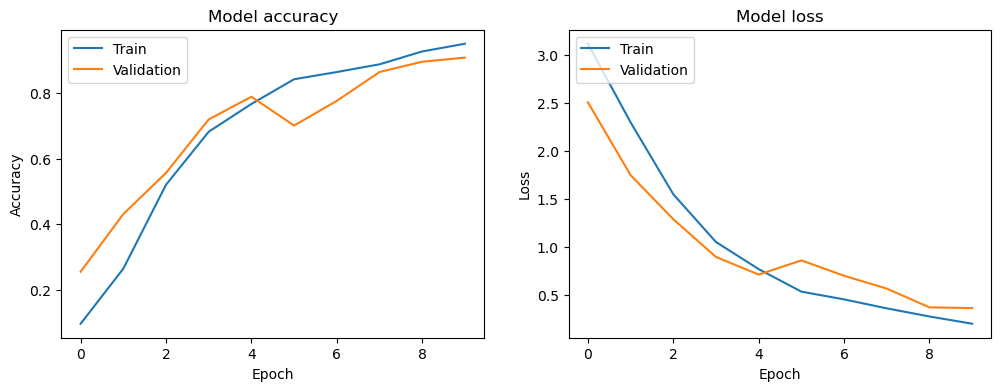

In [20]:
#Testing Tubular Fruits
fruits = [
    "Eggplant", "Avocado", "Avocado Ripe", "Banana", "Banana Lady Finger", "Banana Red",
    "Cactus fruit", "Carambula", "Corn", "Cucumber Ripe", "Hazelnut", "Kumquats",
    "Pear 2", "Pear Red", "Pepino", "Tomato 2", "Nut Pecan", "Melon Piel de Sapo",
    "Pear Abate", "Corn Husk"
]
fruits = np.array(fruits)

# Generate dataset 
image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)

# Encode labels to numeric values
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Reshape data if needed
image_dataset = image_dataset.reshape((image_dataset.shape[0], -1))

# Function to create the ANN model
def create_ann_model(input_shape, num_classes):
    model = Sequential([
        Dense(1024, activation='relu', input_shape=input_shape),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Nadam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
cv_scores = []

for train_index, val_index in kf.split(image_dataset):
    X_train, X_val = image_dataset[train_index], image_dataset[val_index]
    y_train, y_val = labels_encoded[train_index], labels_encoded[val_index]
    
    model = create_ann_model((resizes[0] * resizes[1] * 3,), len(fruits))
    
    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), verbose=0)
    
    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f'Fold {fold_no} - Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f}')
    
    cv_scores.append(val_accuracy)
    fold_no += 1

print(f'Cross-Validation Score: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}')

# Train final model on the entire training data
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_encoded, test_size=0.2, random_state=42)
final_model = create_ann_model((resizes[0] * resizes[1] * 3,), len(fruits))
history = final_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)

# Evaluate the final model on the test data
y_pred_ann = np.argmax(final_model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred_ann, target_names=label_encoder.classes_))
cm = confusion_matrix(y_test, y_pred_ann)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Random Fruits

In [21]:
count = 40
sample_size = 1000

C:\Users\John\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 - Validation Loss: 0.1049 - Validation Accuracy: 0.9650
Fold 2 - Validation Loss: 0.4068 - Validation Accuracy: 0.8700
Fold 3 - Validation Loss: 0.2999 - Validation Accuracy: 0.9250
Fold 4 - Validation Loss: 0.2639 - Validation Accuracy: 0.9350
Fold 5 - Validation Loss: 0.3938 - Validation Accuracy: 0.8900
Cross-Validation Score: 0.9170 ± 0.0336
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.0451 - loss: 3.7535 - val_accuracy: 0.1250 - val_loss: 3.0523
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.2099 - loss: 2.7950 - val_accuracy: 0.3438 - val_loss: 2.0915
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4558 - loss: 1.7396 - val_accuracy: 0.6125 - val_loss: 1.3950
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6809 - loss: 1.1184 - val_accuracy: 0.7812 - val_loss: 0.9750
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8047 - loss: 0.7449 - val_accuracy: 0.8188 - val_loss: 0.7433
Epoch 6/10

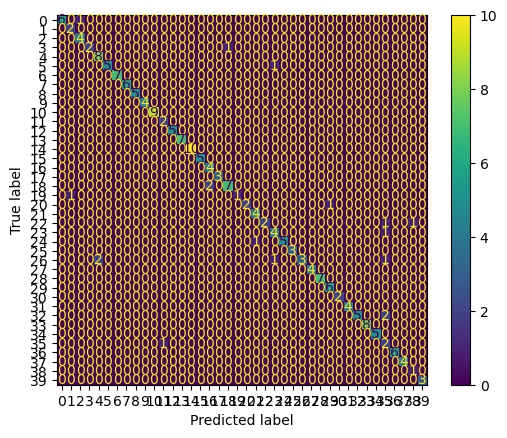

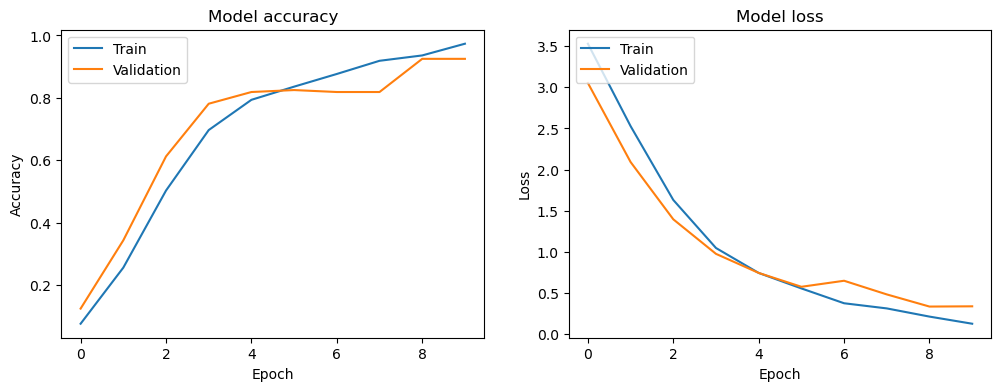

In [22]:
#Random Fruits 1
fruits = getRandomFruitDirs(count)
fruits = np.array(fruits)

# Generate dataset 
image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)

# Encode labels to numeric values
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Reshape data if needed
image_dataset = image_dataset.reshape((image_dataset.shape[0], -1))

# Function to create the ANN model
def create_ann_model(input_shape, num_classes):
    model = Sequential([
        Dense(1024, activation='relu', input_shape=input_shape),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Nadam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
cv_scores = []

for train_index, val_index in kf.split(image_dataset):
    X_train, X_val = image_dataset[train_index], image_dataset[val_index]
    y_train, y_val = labels_encoded[train_index], labels_encoded[val_index]
    
    model = create_ann_model((resizes[0] * resizes[1] * 3,), len(fruits))
    
    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), verbose=0)
    
    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f'Fold {fold_no} - Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f}')
    
    cv_scores.append(val_accuracy)
    fold_no += 1

print(f'Cross-Validation Score: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}')

# Train final model on the entire training data
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_encoded, test_size=0.2, random_state=42)
final_model = create_ann_model((resizes[0] * resizes[1] * 3,), len(fruits))
history = final_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)

# Evaluate the final model on the test data
y_pred_ann = np.argmax(final_model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred_ann, target_names=label_encoder.classes_))
cm = confusion_matrix(y_test, y_pred_ann)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

C:\Users\John\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 - Validation Loss: 0.2337 - Validation Accuracy: 0.9550
Fold 2 - Validation Loss: 0.2344 - Validation Accuracy: 0.9250
Fold 3 - Validation Loss: 0.2655 - Validation Accuracy: 0.9400
Fold 4 - Validation Loss: 0.2383 - Validation Accuracy: 0.9350
Fold 5 - Validation Loss: 0.2003 - Validation Accuracy: 0.9400
Cross-Validation Score: 0.9390 ± 0.0097
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.0574 - loss: 3.7326 - val_accuracy: 0.1813 - val_loss: 3.0385
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.2630 - loss: 2.6578 - val_accuracy: 0.5250 - val_loss: 1.6995
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5618 - loss: 1.5141 - val_accuracy: 0.6562 - val_loss: 1.0962
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7252 - loss: 0.9111 - val_accuracy: 0.8375 - val_loss: 0.6404
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8176 - loss: 0.5856 - val_accuracy: 0.8500 - val_loss: 0.5777
Epoch 6/10

C:\Users\John\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\John\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\John\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


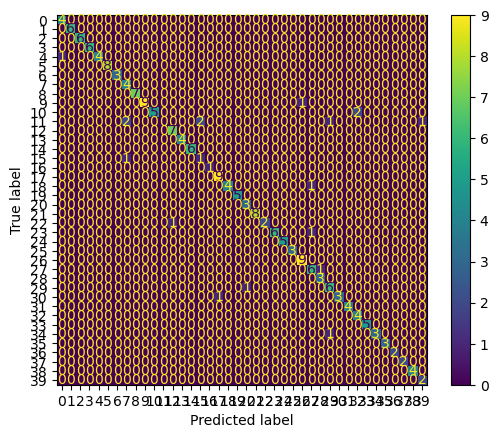

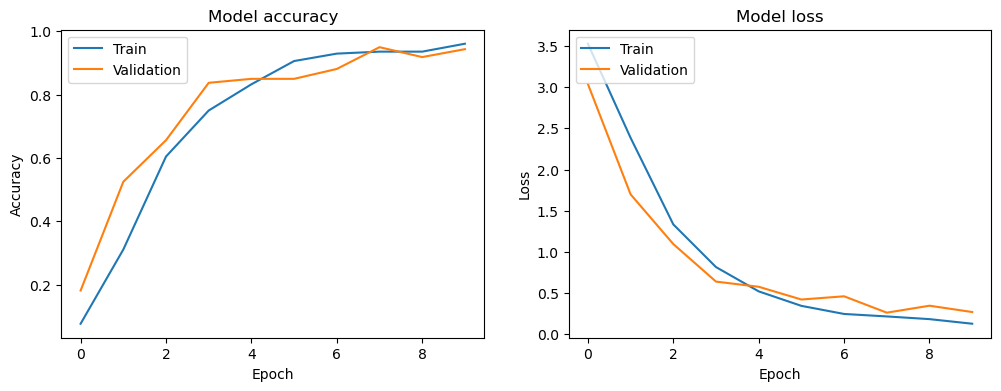

In [23]:
#Random Fruits 2
fruits = getRandomFruitDirs(count)
fruits = np.array(fruits)

# Generate dataset 
image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)

# Encode labels to numeric values
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Reshape data if needed
image_dataset = image_dataset.reshape((image_dataset.shape[0], -1))

# Function to create the ANN model
def create_ann_model(input_shape, num_classes):
    model = Sequential([
        Dense(1024, activation='relu', input_shape=input_shape),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Nadam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
cv_scores = []

for train_index, val_index in kf.split(image_dataset):
    X_train, X_val = image_dataset[train_index], image_dataset[val_index]
    y_train, y_val = labels_encoded[train_index], labels_encoded[val_index]
    
    model = create_ann_model((resizes[0] * resizes[1] * 3,), len(fruits))
    
    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), verbose=0)
    
    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f'Fold {fold_no} - Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f}')
    
    cv_scores.append(val_accuracy)
    fold_no += 1

print(f'Cross-Validation Score: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}')

# Train final model on the entire training data
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_encoded, test_size=0.2, random_state=42)
final_model = create_ann_model((resizes[0] * resizes[1] * 3,), len(fruits))
history = final_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)

# Evaluate the final model on the test data
y_pred_ann = np.argmax(final_model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred_ann, target_names=label_encoder.classes_))
cm = confusion_matrix(y_test, y_pred_ann)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

C:\Users\John\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 - Validation Loss: 0.3155 - Validation Accuracy: 0.9000
Fold 2 - Validation Loss: 0.2993 - Validation Accuracy: 0.9000
Fold 3 - Validation Loss: 0.3511 - Validation Accuracy: 0.9050
Fold 4 - Validation Loss: 0.4083 - Validation Accuracy: 0.9000
Fold 5 - Validation Loss: 0.4262 - Validation Accuracy: 0.8500
Cross-Validation Score: 0.8910 ± 0.0206
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.0432 - loss: 3.8072 - val_accuracy: 0.1875 - val_loss: 3.2423
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.1962 - loss: 3.0160 - val_accuracy: 0.3063 - val_loss: 2.3739
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4265 - loss: 1.9784 - val_accuracy: 0.6000 - val_loss: 1.5099
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.6140 - loss: 1.2345 - val_accuracy: 0.6562 - val_loss: 1.1654
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7688 - loss: 0.8258 - val_accuracy: 0.5875 - val_loss: 1.2331
Epoch 6/10

C:\Users\John\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\John\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\John\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


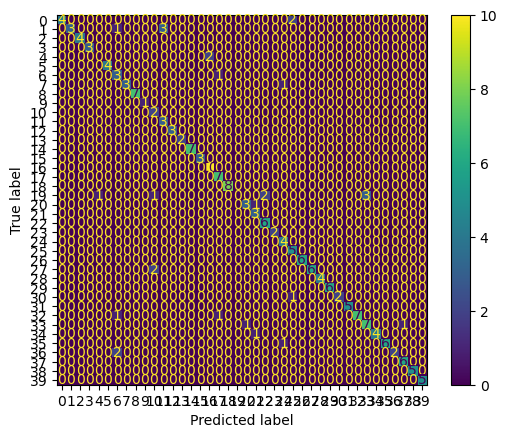

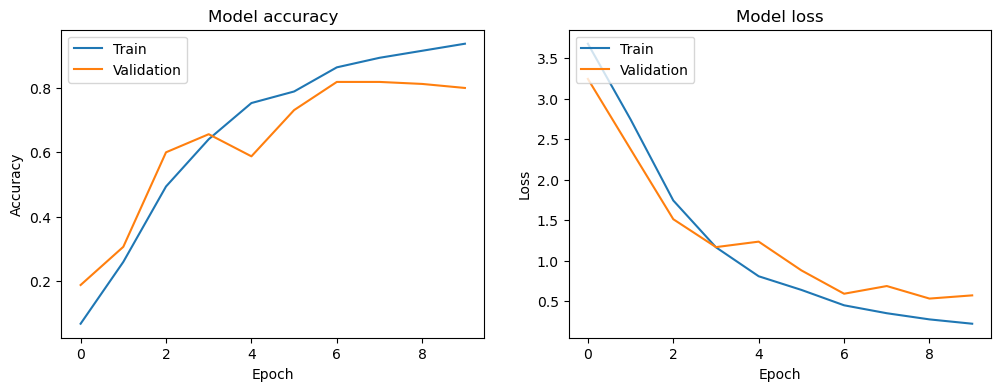

In [24]:
#Random Fruits 3
fruits = getRandomFruitDirs(count)
fruits = np.array(fruits)

# Generate dataset 
image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)

# Encode labels to numeric values
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Reshape data if needed
image_dataset = image_dataset.reshape((image_dataset.shape[0], -1))

# Function to create the ANN model
def create_ann_model(input_shape, num_classes):
    model = Sequential([
        Dense(1024, activation='relu', input_shape=input_shape),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Nadam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
cv_scores = []

for train_index, val_index in kf.split(image_dataset):
    X_train, X_val = image_dataset[train_index], image_dataset[val_index]
    y_train, y_val = labels_encoded[train_index], labels_encoded[val_index]
    
    model = create_ann_model((resizes[0] * resizes[1] * 3,), len(fruits))
    
    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), verbose=0)
    
    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f'Fold {fold_no} - Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f}')
    
    cv_scores.append(val_accuracy)
    fold_no += 1

print(f'Cross-Validation Score: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}')

# Train final model on the entire training data
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_encoded, test_size=0.2, random_state=42)
final_model = create_ann_model((resizes[0] * resizes[1] * 3,), len(fruits))
history = final_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)

# Evaluate the final model on the test data
y_pred_ann = np.argmax(final_model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred_ann, target_names=label_encoder.classes_))
cm = confusion_matrix(y_test, y_pred_ann)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()